In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imread
from nansat import Nansat, Domain, Mosaic
from boreali import Boreali, lm
import pandas as pd 
import csv

%matplotlib nbagg

In [2]:
# Test img file name path: ./data/A2014301181500.L2_LAC_OC.x.nc

# Bathymetry file path: ./data/michigan_lld.grd
# source: https://www.ngdc.noaa.gov/mgg/greatlakes/michigan.html
# units: meters

img = Nansat('./data/A2014301181500.L2_LAC_OC.x.nc')
bathymetry = Nansat('./data/michigan_lld.grd')

# 300, 200 - May it be problem? 
dom = Domain('+proj=latlong +datum=WGS84 +ellps=WGS84 +no_defs', '-lle -86.3 44.6 -85.2 45.3 -ts 122 78')
# Each point is ~ 0.4 km (300x200)
# Each point is ~ 1.0 km (122x78)

img.reproject(dom)
bathymetry.reproject(dom)

=>michigan.grd<=


In [3]:
# preparing of bottom field
h = bathymetry[1]
# all points there h >= 0 will marked as np.nan
h = np.where(h >= 0, np.nan, np.array(h) * -1)
# the mask of land 
h_mask = np.where(np.isfinite(h), np.nan, np.array(1))

# the mask which shows 10 meters depth zone
h_10m = np.where(h <= 10, np.array(1), np.nan)

In [6]:
def show_it(obj, name, color='jet', limits=None, z10='off', size=(9, 6)):
    plt.figure(figsize=size)
    plt.imshow(obj, clim=limits, cmap=color)
    plt.colorbar()

    # Coordinate grid params
    y = np.arange(0.0, 79.0, 79.0 / 7)
    y_labels = np.arange(45.3, 44.5, -0.1)
    x = np.arange(0.0, 123.0, 123.0 / 11)
    x_labels = np.arange(86.3, 85.2, -0.1)

    plt.title(name, y=1.08, fontsize=16)
    plt.yticks(y, y_labels)
    plt.xticks(x, x_labels)
    plt.tick_params(labelsize=14)

    # black field is area which depth less than 10 meters
    if z10 == 'on': plt.imshow(h_10m, cmap='gray')
    plt.imshow(h_mask, cmap='Dark2')
    plt.grid(color='black')

<IPython.core.display.Javascript object>


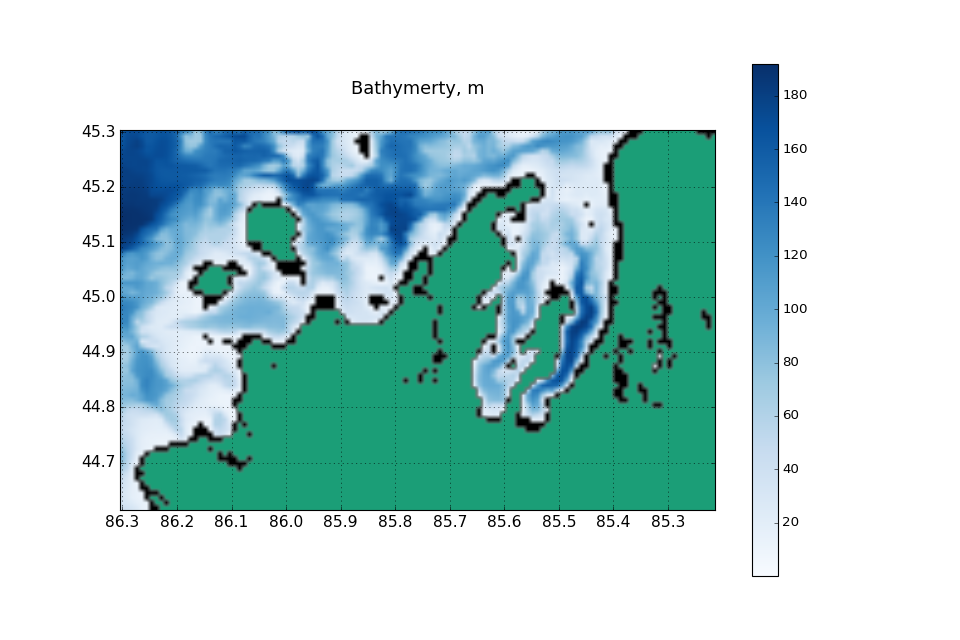

In [9]:
# plotting of bottom field
# blue is water, green is land, black is zone of less than 10 meters depth
show_it(h, 'Bathymerty, m', color='Blues', z10='on', size=(12,8))

In [182]:
# List of sets of bands  which were used to boreali processing:

wavelens_base = [412, 443, 469, 488, 531, 547, 555, 645, 667, 678]   # All MODIS channels
wavelens_blue_off = [443, 469, 488, 531, 547, 555, 645, 667, 678]    # Without 412 nm
wavelens_1x1km_bands = [412, 443, 488, 531, 645, 678]   # Only 1x1 km spatial resolution bands
wavelens_red_off = [412, 443, 469, 488, 531, 547, 555, 645, 667]    # Without 678 nm
wavelens_blueandred_off = [443, 469, 488, 531, 547, 555, 645, 667]   # Without 412 nm and 678 nm

In [101]:
def boreali_processing(n_img, wavelens, h, osw_mod='on'):
    """
    :param n_img: Nansat img
    :param wavelen: nupy array (vector) of wave lenghts
    :param h: numpy array of bottom deph was got from michigan_lld.grd
    :param osw_mod: Need i to use OSW ?  
    :return: numpy array custom_n which contain Rrs, Rrsw and CPA data
    """
    cpa_limits = [0.01, 3, 
                  0.01, 1, 
                  0.01, 1, 10]
    
    b = Boreali('michigan', wavelens)
    theta = np.zeros_like(n_img[2])
    custom_n = Nansat(domain=n_img)
    band_rrs_numbers = list(map(lambda x: n_img._get_band_number('Rrs_' + str(x)), wavelens)) 
    
    for index in range(0, len(wavelens)):
        rrsw = n_img[band_rrs_numbers[index]] / (0.52 + 1.7 * n_img[band_rrs_numbers[index]])   
        custom_n.add_band(rrsw, parameters={'name': 'Rrsw_' + str(wavelens[index]),  
                                            'units': 'sr-1',
                                            'wavelength': wavelens[index]})
        
        # If we want to use OSW mod, we will need to add Rrs data in custom_n obj
        if osw_mod == 'on':
            custom_n.add_band(n_img[band_rrs_numbers[index]], parameters={'name': 'Rrs_' + str(wavelens[index]),
                                                                          'units': 'sr-1',
                                                                          'wavelength': wavelens[index]})
    # Creating of the mask
    # All pixels marked as -0.015534 in img will marked as 0.0 in the mask
    mask = np.where(n_img[2] != np.float(-0.015534), np.array(64.0), np.array(0.0)) 
    # Validation of mask according to bathymetry data.
    # If in the bathymetry pixel was marked as np.nan, in mask he will marked as 0.0
    # else nothing
    mask = np.where(np.isnan(h), np.array(0.), mask)
    # Adding of mask into custom_n obj
    custom_n.add_band(mask, parameters={'name' : 'mask'})
    
    # h is trigger for OWS processing mod. 
    # If want to star OSW we will need to add h to Boreali.process
    # else marked it as None
    if osw_mod == 'on': 
        depth = h
    else: 
        depth = None
    
    cpa = b.process(custom_n, cpa_limits,  mask=custom_n['mask'], depth=depth, theta=theta, threads=4)

    custom_n.add_band(array=cpa[0], parameters={'name': 'chl',
                                                'long_name': 'Chlorophyl-a',
                                                'units': 'mg m-3'})
    custom_n.add_band(array=cpa[1], parameters={'name': 'tsm',
                                                'long_name': 'Total suspended matter',
                                                'units': 'g m-3'})
    custom_n.add_band(array=cpa[2], parameters={'name': 'doc',
                                                        'long_name': 'Dissolved organic carbon',
                                                'units': 'gC m-3'})
    custom_n.add_band(array=cpa[3], parameters={'name': 'mse',
                                                'long_name': 'Root Mean Square Error',
                                                'units': 'sr-1'})
    custom_n.add_band(array=cpa[4], parameters={'name': 'mask',
                                                'long_name': 'L2 Boreali mask',
                                                'units': '1'})
    
    #   custom_n.export(final_path + obj.split('/')[-1] + 'cpa_OSW.nc')
    return custom_n

In [173]:
def get_r(obj, coords, r_type, wavelens):
    y, x = coords
    band_numbers = list(map(lambda x: obj._get_band_number(r_type + str(x)), wavelens))
    r_list = [obj[band][y][x] for band in band_numbers]
    return r_list


def plot_r(obj, wavelens, coords, r_type='Rrs_', size=(9, 6)):
    y, x = coords
    r_list = get_r(obj, coords, r_type, wavelens)
    num_bands = range(0, len(r_list))

    plt.figure(figsize=size)
    plt.title('%s / Index: (x: %d, y:%d) / Depth: %5.2f)' % (r_type, x, y, h[y, x]))
    plt.plot(num_bands, r_list)
    plt.xticks(num_bands, wavelens)
    plt.xlabel('wavelength, nm')
    plt.ylabel('%s, sr^-1' % (r_type))
    plt.grid(color='black')
    # plt.ylim([0, 0.04])

In [170]:
def boreali_lm(obj, wavelens, h, coords, show='on'):
    y, x = coords
    b = Boreali('michigan', wavelens)
    model = b.get_homodel()
    theta = 0
    albedoType = 0
    depth = h[y,x]
    albedo = b.get_albedo([albedoType])[0]

    cpa_limits = [0.01, 3,
                  0.01, 1,
                  0.01, 1, 10]

    r = get_r(obj, (y, x), 'Rrsw_', wavelens)    #
    c_deep = lm.get_c_deep(cpa_limits, model, [r], [theta], 4)[1]
    c_osw = lm.get_c_shal(cpa_limits, model, [r], [theta], [depth], [albedo], 4)[1]

    if show == 'on':
        print 'BOREALI DEEP: chl=%5.2f, tsm=%5.2f, doc=%5.2f, rmse=%5.2f' % tuple(c_deep)
        print 'BOREALI OSW: chl=%5.2f, tsm=%5.2f, doc=%5.2f, rmse=%5.2f' % tuple(c_osw)
        plot_r(obj, wavelens=wavelens, coords=(y, x), size=(10, 4))
    else:
        return c_osw, c_deep, depth

BOREALI DEEP: chl= 0.01, tsm= 0.05, doc= 0.08, rmse= 0.00
BOREALI OSW: chl= 1.18, tsm= 0.01, doc= 0.03, rmse= 0.00


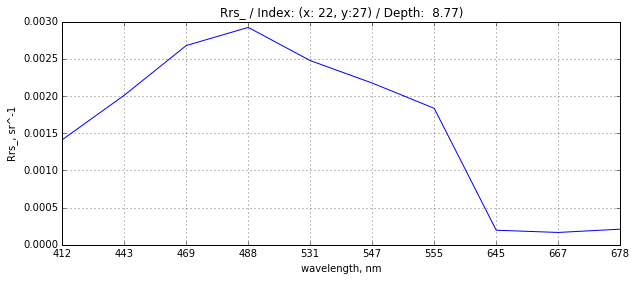

In [174]:
boreali_lm(test1, wavelens_base, h, (27, 22))

In [62]:
test1 = boreali_processing(img, wavelens_base, h, osw_mod='on')

wavelen [412.0, 443.0, 469.0, 488.0, 531.0, 547.0, 555.0, 645.0, 667.0, 678.0]
R Name is  Rrs_
(10, 78, 122)
Pixels x bands to process:  (3360, 10)
launch shallow
launch shallow
launch shallow
launch shallow
spent:  7.32395386696


In [181]:
def find_valid_points(coord_list):
    points = [] 
    for i in range(0, len(coord_list)):
        y,x = coord_list[i]
        if np.nan not in h[y-1:y+2, x-1:x+2] and y not in (0, 78) and x not in (0, 122):
            points.append(coord_list[i])
    return points

# We get a list of coordinates (tuple of (y,x) indexes of px) 
# of points which shallower then 10 m
coords = zip(*np.where(h_10m == 1)) 
# Checking that the pixel situated farther than 1 px (1 km) from the coast?
pixels = find_valid_points(coords)

In [ ]:
positive_px = []
for pixel in pixels:
    flag = 1
    r = get_r(test1, pixel, 'Rrs_', wavelens_base)
    for i in r:
        if i < 0:
            flag = 0
    if flag == 1: positive_px.append(pixel)
print len(positive_px)

In [145]:
with open('test1.csv', 'w') as csvfile:
    fieldnames = ['coordinates', 'alg_type', 'h', 'chl', 'tsm', 'doc', 'rmse']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    for el in positive_px:
        osw, deep, depth = boreali_lm(test1, wavelens_base, h, el)
        writer.writerow({
            'coordinates': el,
            'alg_type': 'osw',
            'h': round(depth,2),
            'chl': round(osw[0],2),
            'tsm': round(osw[1], 2),
            'doc': round(osw[2], 2),
            'rmse': round(osw[3], 2)
            })
        
        writer.writerow({
            'coordinates': el,
            'alg_type': 'deep',
            'h': round(depth,2),
            'chl': round(deep[0],2),
            'tsm': round(deep[1], 2),
            'doc': round(deep[2], 2),
            'rmse': round(deep[3], 2)
            })

In [180]:
test = pd.read_csv('test.csv')

In [43]:
test2 = boreali_processing(img, wavelens_base, h, osw_mod='off')

wavelen [412.0, 443.0, 469.0, 488.0, 531.0, 547.0, 555.0, 645.0, 667.0, 678.0]
R Name is  Rrs_
Pixels x bands to process:  (3360, 10)
launch shallow
launch shallow
launch shallow
launch shallow
spent:  4.72083997726
wavelen [412.0, 443.0, 469.0, 488.0, 531.0, 547.0, 555.0, 645.0, 667.0, 678.0]
R Name is  Rrsw_
Pixels x bands to process:  (3360, 10)
launch deep
launch deep
launch deep
launch deep
spent:  2.86222505569


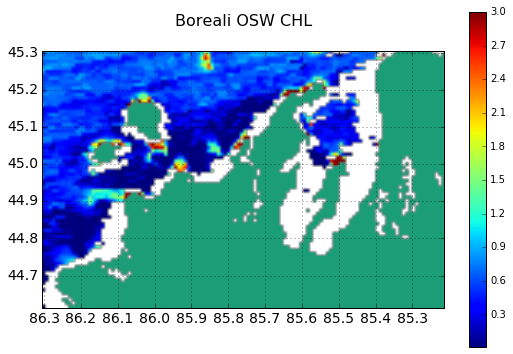

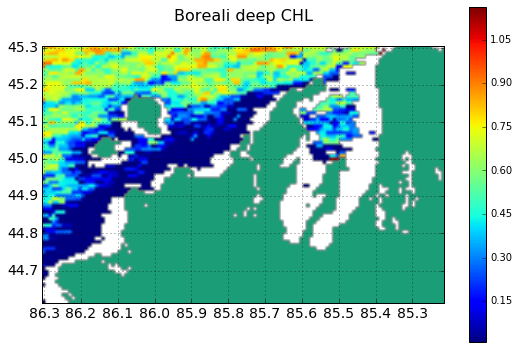

In [44]:
show_it(test1['chl'], name='Boreali OSW CHL')
show_it(test2['chl'], name='Boreali deep CHL')

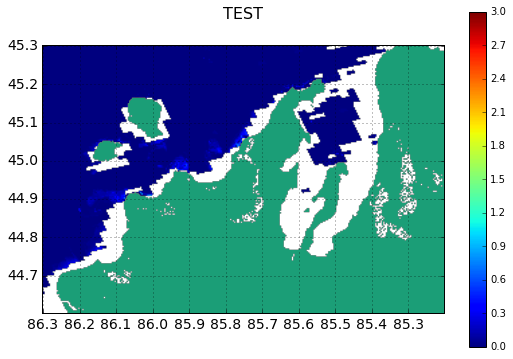

In [49]:
show_it(test1['chl']-test8['chl'], name='TEST')

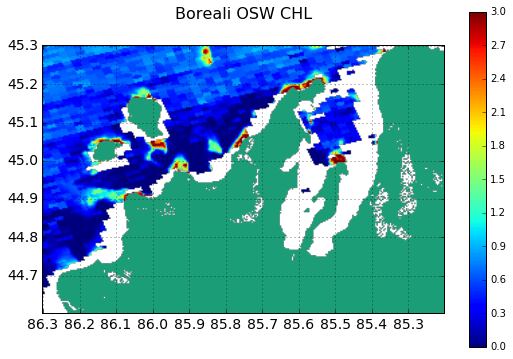

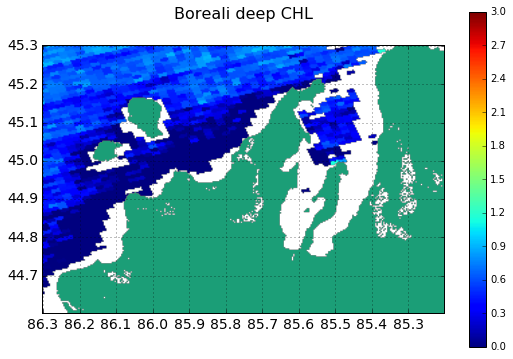

In [96]:
show_it(test['chl'], name='Boreali OSW CHL')
show_it(test2['chl'], name='Boreali deep CHL')

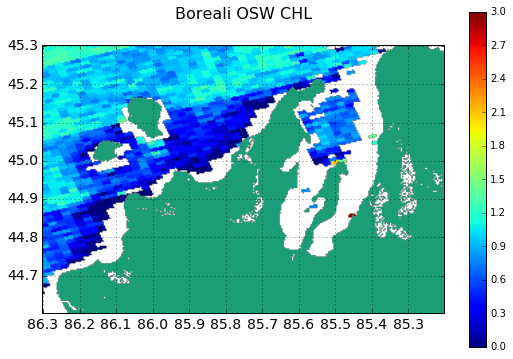

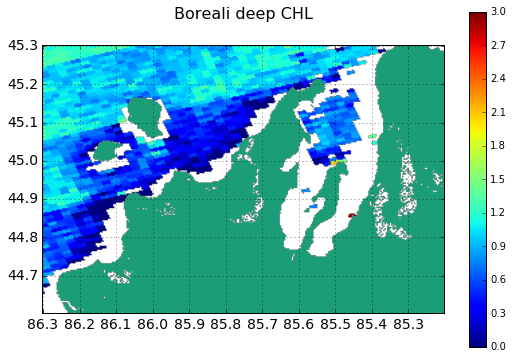

In [97]:
show_it(test3['chl'], name='Boreali OSW CHL')
show_it(test4['chl'], name='Boreali deep CHL')

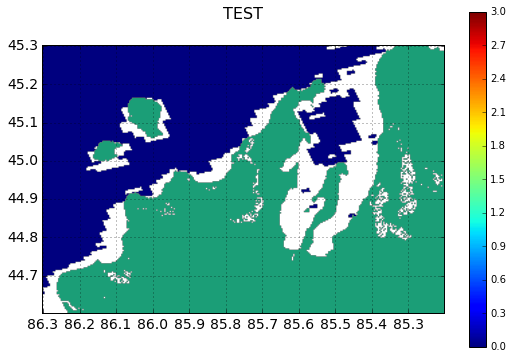

In [98]:
show_it(test3['chl'] - test4['chl'], name='TEST')

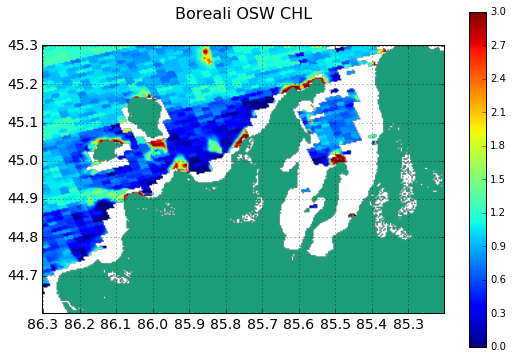

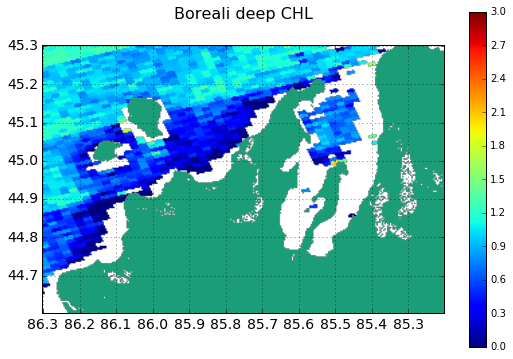

In [100]:
show_it(test5['chl'], name='Boreali OSW CHL')
show_it(test6['chl'], name='Boreali deep CHL')

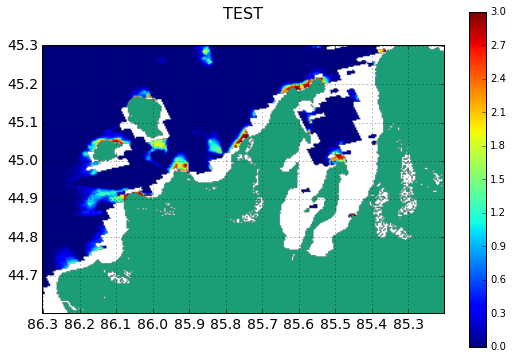

In [101]:
show_it(test5['chl'] - test6['chl'], name='TEST')

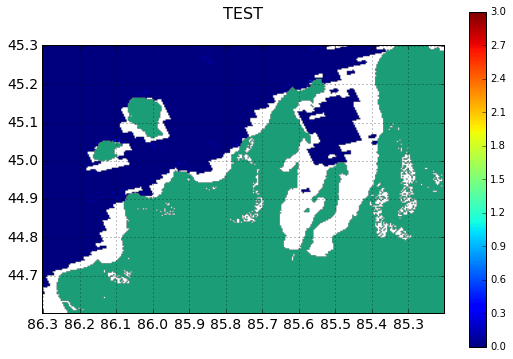

In [106]:
show_it(test['chl'] - test7['chl'], name='TEST')

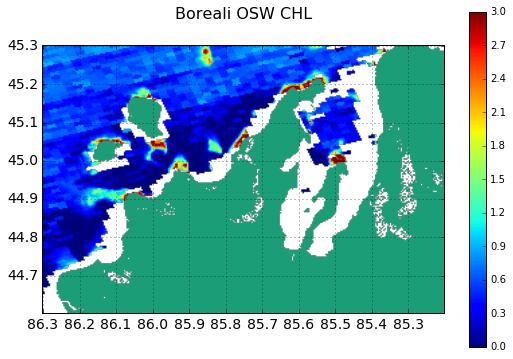

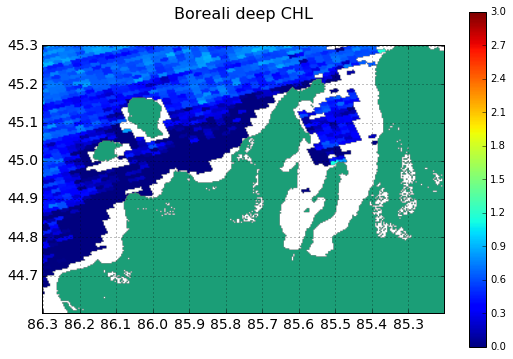

In [105]:
show_it(test7['chl'], name='Boreali OSW CHL')
show_it(test8['chl'], name='Boreali deep CHL')

    fig_params = {'legend': True,
                  'LEGEND_HEIGHT': 0.5,
                  'NAME_LOCATION_Y': 0,
                  'mask_array': cpa[4],
                  'mask_lut': {1: [255, 255, 255],
                               2: [128, 128, 128],
                               4: [200, 200, 255]}}
    custom_n.write_figure(final_path + obj.split('/')[-1] + 'chl_OSW.png', 'chl', clim=[0, 1.], **fig_params)
    custom_n.write_figure(final_path + obj.split('/')[-1] + 'tsm_OSW.png', 'tsm', clim=[0, 1.], **fig_params)
    custom_n.write_figure(final_path + obj.split('/')[-1] + 'doc_OSW.png', 'doc', clim=[0, .2], **fig_params)
    custom_n.write_figure(final_path + obj.split('/')[-1] + 'mse_OSW.png', 'mse', clim=[1e-5, 1e-2],
                          logarithm=True, **fig_params)
    n.write_figure(final_path + obj.split('/')[-1] + 'rgb_OSW.png',
                   [16, 14, 6],
                   clim=[[0, 0, 0], [0.006, 0.04, 0.024]],
                   mask_array=cpa[4],
                   mask_lut={2: [128, 128, 128]})